In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math
from prettytable import PrettyTable
from scipy import sparse
import csv
import graphviz

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, make_scorer
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scipy.stats import randint

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
pt = PrettyTable()
pt.field_names = ["Model", "Optimal 'max_depth'", "Scoring Metric", "Accuracy", "TPR", "TNR", "FPR", "FNR"]

In [3]:
def split_data(train, train_vectors, test, test_vectors, dense_matrix=False):
    
    y_train = train['Score']
    X_train = train.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text', 'CleanedText'], axis=1)

    print(X_train.shape, train_vectors.shape)
    if dense_matrix:
        X_train = np.hstack((X_train, train_vectors))
    else:
        X_train = sparse.hstack((X_train, train_vectors))
    
    print('X_Train: {0}'.format(X_train.shape))
    print('y_Train: {0}'.format(y_train.shape))
    
    y_test = test['Score']
    X_test = test.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text', 'CleanedText'], axis=1)

    if dense_matrix:
        X_test = np.hstack((X_test, test_vectors))
    else:
        X_test = sparse.hstack((X_test, test_vectors))
    
    print('X_Test: {0}'.format(X_test.shape))
    print('y_Test: {0}'.format(y_test.shape))
    
    return X_train, y_train, X_test, y_test

In [4]:
def plot_scores(optimal_model, param):
    _, = plt.plot(list(optimal_model.cv_results_[f'param_{param}']), \
                      list(optimal_model.cv_results_['mean_train_score']), 'g-', \
                     label='Training Scores')
    _, = plt.plot(list(optimal_model.cv_results_[f'param_{param}']), \
                      list(optimal_model.cv_results_['mean_test_score']), 'r-', \
                      label='Test Scores')
    _, = plt.plot(optimal_model.best_params_[param], optimal_model.best_score_, 'bo', \
            label=f"Optimal Value ({param}={optimal_model.best_params_[param]}, Score={round(optimal_model.best_score_,2)})")

    plt.xlabel(param)
    plt.ylabel('Scores')
    plt.legend()
    plt.show()

In [5]:
def run_DT(train, train_vectors, test, test_vectors, kernel='linear', \
            metric='precision_macro', dense_matrix=True):
    '''
    Perform DT Classification modelling on the I/P Train and Test data.
    1. Remove not required Columns and concatenate data with the text vectors.
    2. Perform Cross Validation and find Optimal parameters - 'max_depth',
        'min_samples_split', 'min_samples_leaf', 'max_features' and 'class_weight'.
    3. Use the Optimal parameters based model on the Training data and evaluate the Test data.
    4. Evaluate Performance of Model based on TPR, TNR, FPR, FNR.
    '''
    # Drop not required Columns and concatenate data with text vectors
    X_train, y_train, X_test, y_test = split_data(train, train_vectors, test, \
                                                  test_vectors, dense_matrix=dense_matrix)

    del train, train_vectors, test, test_vectors
    
    parameters = {'max_depth': randint(3,20),
                  'min_samples_split': randint(25,100),
                  'min_samples_leaf': randint(10, 20),
                  'max_features': ('auto', 'sqrt', 'log2'),
                  'class_weight': (None, 'balanced')}
    
    # Custom Scorer to evaluate the best parameters for highest TNR
    def tnr(y_true, y_pred):
        conf_matrix = confusion_matrix(y_true, y_pred)
        TPR = conf_matrix[1,1]/(conf_matrix[0,1] + conf_matrix[1,1])
        TNR = conf_matrix[0,0]/(conf_matrix[0,0] + conf_matrix[1,0])
        FPR = conf_matrix[1,0]/(conf_matrix[0,0] + conf_matrix[1,0])
        FNR = conf_matrix[0,1]/(conf_matrix[0,1] + conf_matrix[1,1])
        return TNR        
        
    scoring = {'score': make_scorer(tnr)}
    
    dt = DecisionTreeClassifier(random_state=42)
    dt_optimal = RandomizedSearchCV(dt, param_distributions=parameters, cv=3, scoring=scoring, verbose=0, refit='score')
    dt_optimal.fit(X_train, y_train)

    # Plot Train vs Test Scores and the Optimal Parameter
    plot_scores(dt_optimal, 'max_depth')

    # Confusion Matrix for Train Data
    pred = []
    for i in range(0, X_train.shape[0], 2000):
        if dense_matrix:
            test_batch = X_train[i:i+2000]
        else:
            test_batch = X_train.todok()[i:i+2000]
        pred.extend(dt_optimal.predict(test_batch))
    conf_matrix = confusion_matrix(y_train, pred)
    TPR = conf_matrix[1,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    TNR = conf_matrix[0,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FPR = conf_matrix[1,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FNR = conf_matrix[0,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    print('\nConfusion Matrix for Train Data :-')
    print(conf_matrix)
    print("\nTPR: {0} %\nTNR: {1} %\nFPR: {2} %\nFNR: {3} %\n".format(TPR*100, TNR*100, FPR*100, FNR*100))
    
    del X_train, y_train
    
    # Confusion Matrix for Test Data
    pred = []
    for i in range(0, X_test.shape[0], 2000):
        if dense_matrix:
            test_batch = X_test[i:i+2000]
        else:
            test_batch = X_test.todok()[i:i+2000]
        pred.extend(dt_optimal.predict(test_batch))

    ps = accuracy_score(y_test, pred) * 100
    print(f'\nAccuracy of the Optimal Decision Tree Classifier with parameters-{dt_optimal.best_params_} is {ps} %')
    
    conf_matrix = confusion_matrix(y_test, pred)
    TPR = conf_matrix[1,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    TNR = conf_matrix[0,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FPR = conf_matrix[1,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FNR = conf_matrix[0,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    print('\nConfusion Matrix for Test Data :-')
    print(conf_matrix)
    print("\nTPR: {0} %\nTNR: {1} %\nFPR: {2} %\nFNR: {3} %\n".format(TPR*100, TNR*100, FPR*100, FNR*100))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
    print('\nClassification Report :-\n')
    print(classification_report(y_test, pred))
    
    return [dt_optimal.best_params_, "True Negative Rate", round(ps,2), round(TPR*100,2), round(TNR*100,2), \
            round(FPR*100,2), round(FNR*100,2), dt_optimal.cv_results_, dt_optimal.best_estimator_]

In [6]:
data_train = pd.read_csv('./Matrices/data_train.csv')
data_test = pd.read_csv('./Matrices/data_test.csv')

## BOW Vectorizer based Decision Tree Model

In [7]:
%%time
cv_model = CountVectorizer(max_features=7000, min_df=10)
bow_counts_train = cv_model.fit_transform(data_train['CleanedText'].values)
bow_counts_test = cv_model.transform(data_test['CleanedText'].values)
print(bow_counts_train.shape, bow_counts_test.shape)

(56000, 6604) (24000, 6604)
Wall time: 5.29 s


(56000, 4) (56000, 6604)
X_Train: (56000, 6608)
y_Train: (56000,)
X_Test: (24000, 6608)
y_Test: (24000,)


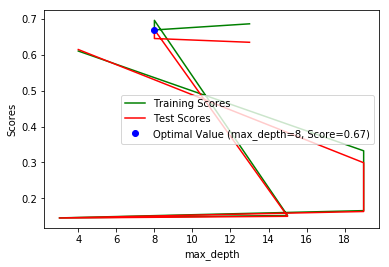


Confusion Matrix for Train Data :-
[[  705  6957]
 [  311 48027]]

TPR: 87.34722828459188 %
TNR: 69.38976377952756 %
FPR: 30.61023622047244 %
FNR: 12.652771715408118 %


Accuracy of the Optimal Decision Tree Classifier with parameters-{'class_weight': None, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 45} is 83.95416666666667 %

Confusion Matrix for Test Data :-
[[  385  3714]
 [  137 19764]]

TPR: 84.18093534372603 %
TNR: 73.75478927203065 %
FPR: 26.245210727969347 %
FNR: 15.819064656273959 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.74      0.09      0.17      4099
          1       0.84      0.99      0.91     19901

avg / total       0.82      0.84      0.78     24000

Wall time: 3min 44s


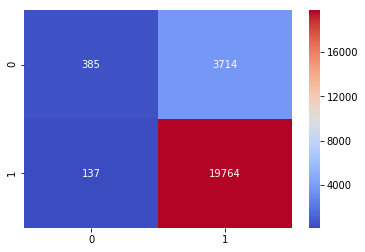

In [8]:
%%time
info = run_DT(data_train, bow_counts_train.toarray(), data_test, bow_counts_test.toarray())

In [9]:
%%time
n = 20; model = info[-1]; coeffs = info[-1].feature_importances_; coef_pt = PrettyTable();
coef_pt.field_names = ["Coefficient", "Best Informative Features"]
feature_names = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'TextLength'] \
                + cv_model.get_feature_names()
coefs_with_fns = sorted(zip(coeffs, feature_names), reverse=True)
top = coefs_with_fns[:n]
for (coef_1, fn_1) in top:
    coef_pt.add_row([round(coef_1,3), fn_1])
print(coef_pt)

export_graphviz(model, out_file='tree.dot', filled=True, feature_names=feature_names, \
               class_names=['Negative Review', 'Positive Review'])
! dot -Tpng tree.dot -o BOW.png

+-------------+---------------------------+
| Coefficient | Best Informative Features |
+-------------+---------------------------+
|    0.235    |            wast           |
|    0.206    |           worst           |
|    0.119    |   HelpfulnessDenominator  |
|    0.092    |           would           |
|    0.087    |           bewar           |
|    0.052    |          perfect          |
|    0.037    |            weak           |
|    0.029    |            keep           |
|     0.02    |           great           |
|    0.017    |           strong          |
|    0.016    |            food           |
|    0.011    |           famili          |
|    0.006    |           price           |
|    0.006    |            rip            |
|    0.006    |           small           |
|    0.006    |           china           |
|    0.006    |           overal          |
|    0.005    |            bit            |
|    0.004    |          favorit          |
|    0.004    |           nasti 

In [10]:
%%time
pt.add_row(['BOW'] + [i for i in str(info[0]['max_depth'])] + info[1:-2])
print(pt)

+-------+---------------------+--------------------+----------+-------+-------+-------+-------+
| Model | Optimal 'max_depth' |   Scoring Metric   | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+-------+---------------------+--------------------+----------+-------+-------+-------+-------+
|  BOW  |          8          | True Negative Rate |  83.95   | 84.18 | 73.75 | 26.25 | 15.82 |
+-------+---------------------+--------------------+----------+-------+-------+-------+-------+
Wall time: 15.6 ms


## TFIDF Vectorizer based Decision Tree Model

In [11]:
%%time
tfidf_model = TfidfVectorizer(max_features=7000, min_df=10)
tfidf_train = tfidf_model.fit_transform(data_train['CleanedText'].values)
tfidf_test = tfidf_model.transform(data_test['CleanedText'].values)
print(tfidf_train.shape, tfidf_test.shape)

(56000, 6604) (24000, 6604)
Wall time: 5.79 s


(56000, 4) (56000, 6604)
X_Train: (56000, 6608)
y_Train: (56000,)
X_Test: (24000, 6608)
y_Test: (24000,)


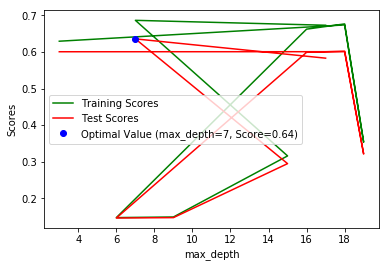


Confusion Matrix for Train Data :-
[[  624  7038]
 [  217 48121]]

TPR: 87.24052285211842 %
TNR: 74.19738406658739 %
FPR: 25.802615933412604 %
FNR: 12.75947714788158 %


Accuracy of the Optimal Decision Tree Classifier with parameters-{'class_weight': None, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 61} is 83.78750000000001 %

Confusion Matrix for Test Data :-
[[  340  3759]
 [  132 19769]]

TPR: 84.02329139748385 %
TNR: 72.03389830508475 %
FPR: 27.966101694915253 %
FNR: 15.976708602516151 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.72      0.08      0.15      4099
          1       0.84      0.99      0.91     19901

avg / total       0.82      0.84      0.78     24000

Wall time: 3min 9s


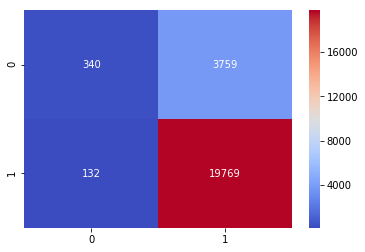

In [12]:
%%time
info = run_DT(data_train, tfidf_train.toarray(), data_test, tfidf_test.toarray())

In [13]:
%%time
n = 20; model = info[-1]; coeffs = info[-1].feature_importances_; coef_pt = PrettyTable();
coef_pt.field_names = ["Coefficient", "Best Informative Features"]
feature_names = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'TextLength'] \
                + tfidf_model.get_feature_names()
coefs_with_fns = sorted(zip(coeffs, feature_names), reverse=True)
top = coefs_with_fns[:n]
for (coef_1, fn_1) in top:
    coef_pt.add_row([round(coef_1,3), fn_1])
print(coef_pt)

export_graphviz(model, out_file='tree.dot', filled=True, feature_names=feature_names, \
               class_names=['Negative Review', 'Positive Review'])
! dot -Tpng tree.dot -o TFIDF.png

+-------------+---------------------------+
| Coefficient | Best Informative Features |
+-------------+---------------------------+
|    0.307    |            wast           |
|    0.265    |           worst           |
|    0.118    |           would           |
|    0.065    |          perfect          |
|    0.053    |            weak           |
|    0.035    |            keep           |
|    0.028    |            poor           |
|    0.025    |            love           |
|    0.018    |            yuck           |
|    0.016    |           famili          |
|    0.011    |            food           |
|    0.011    |            good           |
|     0.01    |           especi          |
|    0.009    |           broken          |
|    0.009    |          purchas          |
|    0.005    |           damag           |
|    0.004    |            mani           |
|    0.004    |           expens          |
|    0.002    |           onlin           |
|    0.001    |           accord

In [14]:
%%time
pt.add_row(['TFIDF'] + [i for i in str(info[0]['max_depth'])] + info[1:-2])
print(pt)

+-------+---------------------+--------------------+----------+-------+-------+-------+-------+
| Model | Optimal 'max_depth' |   Scoring Metric   | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+-------+---------------------+--------------------+----------+-------+-------+-------+-------+
|  BOW  |          8          | True Negative Rate |  83.95   | 84.18 | 73.75 | 26.25 | 15.82 |
| TFIDF |          7          | True Negative Rate |  83.79   | 84.02 | 72.03 | 27.97 | 15.98 |
+-------+---------------------+--------------------+----------+-------+-------+-------+-------+
Wall time: 17 ms


## Avg. W2V Vectorizer based Decision Tree model

In [15]:
%%time
sent_vectors_train = pd.read_csv('./Matrices/avg_w2v_train.csv')
sent_vectors_test = pd.read_csv('./Matrices/avg_w2v_test.csv')

Wall time: 2.69 s


(56000, 4) (56000, 50)
X_Train: (56000, 54)
y_Train: (56000,)
X_Test: (24000, 54)
y_Test: (24000,)


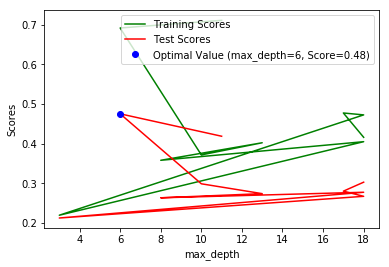


Confusion Matrix for Train Data :-
[[ 2282  5380]
 [ 1120 47218]]

TPR: 89.77147420053994 %
TNR: 67.07818930041152 %
FPR: 32.92181069958848 %
FNR: 10.228525799460057 %


Accuracy of the Optimal Decision Tree Classifier with parameters-{'class_weight': None, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 14, 'min_samples_split': 62} is 85.17083333333333 %

Confusion Matrix for Test Data :-
[[ 1138  2961]
 [  598 19303]]

TPR: 86.700503054258 %
TNR: 65.55299539170507 %
FPR: 34.44700460829493 %
FNR: 13.299496945742003 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.66      0.28      0.39      4099
          1       0.87      0.97      0.92     19901

avg / total       0.83      0.85      0.83     24000

Wall time: 20.3 s


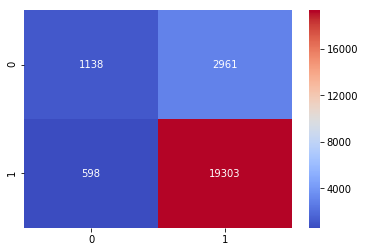

In [17]:
%%time
info = run_DT(data_train, sent_vectors_train, data_test, sent_vectors_test)

In [18]:
%%time
pt.add_row(['Avg. W2V'] + [i for i in str(info[0]['max_depth'])] + info[1:-2])
print(pt)

+----------+---------------------+--------------------+----------+-------+-------+-------+-------+
|  Model   | Optimal 'max_depth' |   Scoring Metric   | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+----------+---------------------+--------------------+----------+-------+-------+-------+-------+
|   BOW    |          8          | True Negative Rate |  83.95   | 84.18 | 73.75 | 26.25 | 15.82 |
|  TFIDF   |          7          | True Negative Rate |  83.79   | 84.02 | 72.03 | 27.97 | 15.98 |
| Avg. W2V |          6          | True Negative Rate |  85.17   |  86.7 | 65.55 | 34.45 |  13.3 |
+----------+---------------------+--------------------+----------+-------+-------+-------+-------+
Wall time: 0 ns


## TFIDF-weighted W2V Vectorizer based Decision Tree Model

In [19]:
%%time
sent_vectors_train = pd.read_csv('./Matrices/tfidf_w2v_train.csv')
sent_vectors_test = pd.read_csv('./Matrices/tfidf_w2v_test.csv')

Wall time: 3.88 s


(56000, 4) (56000, 50)
X_Train: (56000, 54)
y_Train: (56000,)
X_Test: (24000, 54)
y_Test: (24000,)


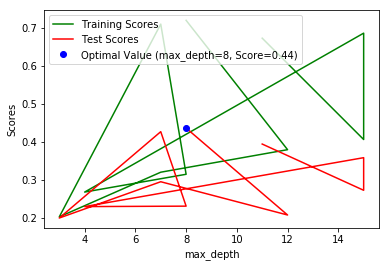


Confusion Matrix for Train Data :-
[[ 2086  5576]
 [  918 47420]]

TPR: 89.47845120386444 %
TNR: 69.44074567243675 %
FPR: 30.559254327563252 %
FNR: 10.521548796135557 %


Accuracy of the Optimal Decision Tree Classifier with parameters-{'class_weight': None, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 71} is 84.6 %

Confusion Matrix for Test Data :-
[[  766  3333]
 [  363 19538]]

TPR: 85.42695990555725 %
TNR: 67.84765279007972 %
FPR: 32.152347209920286 %
FNR: 14.573040094442744 %


Classification Report :-

             precision    recall  f1-score   support

          0       0.68      0.19      0.29      4099
          1       0.85      0.98      0.91     19901

avg / total       0.82      0.85      0.81     24000

Wall time: 19.1 s


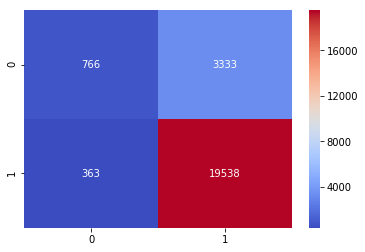

In [20]:
%%time
info = run_DT(data_train, sent_vectors_train, data_test, sent_vectors_test)

In [21]:
%%time
pt.add_row(['TFIDF W2V'] + [i for i in str(info[0]['max_depth'])] + info[1:-2])
print(pt)

+-----------+---------------------+--------------------+----------+-------+-------+-------+-------+
|   Model   | Optimal 'max_depth' |   Scoring Metric   | Accuracy |  TPR  |  TNR  |  FPR  |  FNR  |
+-----------+---------------------+--------------------+----------+-------+-------+-------+-------+
|    BOW    |          8          | True Negative Rate |  83.95   | 84.18 | 73.75 | 26.25 | 15.82 |
|   TFIDF   |          7          | True Negative Rate |  83.79   | 84.02 | 72.03 | 27.97 | 15.98 |
|  Avg. W2V |          6          | True Negative Rate |  85.17   |  86.7 | 65.55 | 34.45 |  13.3 |
| TFIDF W2V |          8          | True Negative Rate |   84.6   | 85.43 | 67.85 | 32.15 | 14.57 |
+-----------+---------------------+--------------------+----------+-------+-------+-------+-------+
Wall time: 16.7 ms


# Conclusions :-
-  The Dataset being highly imbalanced (8:1) the Scoring metric has been selected based on the Model performance of - high TPR & TNR and low FPR & FNR.
-  Based on the above performance criteria, a Custom Scorer has been used to evaluate the best Model w.r.t. True Negative Rate (TNR).
-  From the Performances obtained on the four Vectorizer models, it has been observed that BOW Vectorizer based Decision Tree Model is giving the best True Negative Rate (TNR) with the highest True Positive Rate (TPR). Also, TFIDF Vectorizer based Decision Tree model is giving equally good results.
-  The Optimal Max Depth evaluated by all the models shows that optimal performance is evaluated with a relatively low depth of the Decision Tree (< 10).